## ДЗ №1. Метрики и простейшие алгоритмы рекомендаций  
## Студент - Лялин Дмитрий

## Общая информация
**Дата выдачи: 4 февраля 2025**

**Дедлайн: 12 февраля 2025 23:59 MSK**

Импортируем гугл драйв для чтения датасетов и считаем скрипт metric_tests.py, чтобы не закачивать их в гугл колаб при каждом перезапуске.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import requests
url = "https://raw.githubusercontent.com/anamarina/RecSys_course/refs/heads/2025/hw/metric_tests.py"
response = requests.get(url)
with open("metric_tests.py", "w") as f:
    f.write(response.text)

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from typing import List, Optional
from metric_tests import run_tests

%matplotlib inline

## О задании

В этой работе мы посмотрим на то, как работают самые простые модели для рекомендаций. Как правило, они не требуют построения специальных моделей, но даже так оказываются полезны в качестве бейзлайна. Попробуем сделать предсказания с помощью EASE. Это тоже довольно простой подход, но не стоит забывать, что сложные модели могут оказаться не лучшим выбором в условиях большого количества данных. Посчитаем метрики, построим графики и подумаем, насколько хорошо эти модели вообще решают поставленную задачу.

Мы будем работать с датасетом по рекомендации фильмов от Kion MTS, который был дан для соревнования. Сперва нужно его предобработать, эта часть повторяет то, что было на семинаре.

Датасет необходимо скачать: https://ods.ai/competitions/competition-recsys-21/data

Оттуда нужны файлы `interactions.csv` и `items.csv`

Каждое задание весит **1 балл**, если выполнено полностью и без ошибок, **0 баллов** ставится при наличии хотя бы 1 ошибки. Максимальная оценка - **10 баллов**. Шаблоны функций и классов можно менять по своему усмотрению.

In [ ]:
df = pd.read_csv('/content/drive/My Drive/datasets/recsys_course/interactions.csv').iloc[:-1]
df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [ ]:
df['last_watch_dt'] = (pd.to_datetime(df['last_watch_dt']) - pd.to_datetime(df['last_watch_dt']).min())
df['last_watch_dt'] = df.last_watch_dt.apply(lambda x: int(str(x).split()[0]))
df.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
3163598,586955,13586,103,501,12.0
4369043,8885,1033,148,1398,4.0
5408881,172005,931,51,426,7.0
1275695,1091953,3878,84,456,7.0
4387203,178865,8986,127,6367,95.0


Сделаем разбиение по времени

<Axes: >

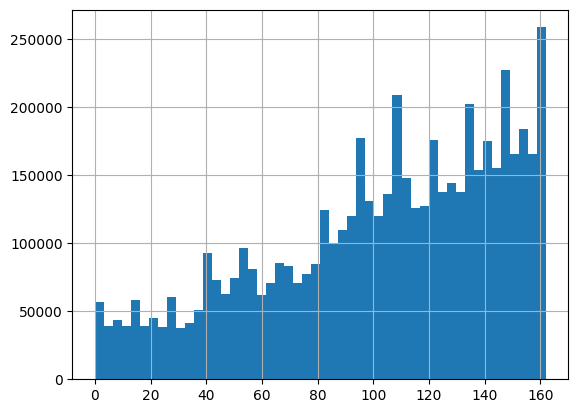

In [ ]:
df.last_watch_dt.hist(bins=50)

In [ ]:
train_df = df.loc[(df.last_watch_dt < 160-7)].copy()
test_df = df.loc[(df.last_watch_dt >= 160-7)].copy()

train_users = train_df.user_id.unique()
test_users = test_df.user_id.unique()

all_included = np.intersect1d(train_users, test_users)

print('число людей и там и там: ', all_included.shape[0])
print('число людей всего:', train_users.shape[0])

число людей и там и там:  134670
число людей всего: 880449


In [ ]:
len(set(test_users) - set(train_users)) / len(test_users)

0.37768022181146027

И переведём всё к соединённому датасету:

In [ ]:
n_users = 10000

all_included = np.random.choice(all_included, size=n_users, replace=False)

train_df = train_df.loc[train_df.user_id.isin(all_included)].copy()
test_df = test_df.loc[test_df.user_id.isin(all_included)].copy()

assert train_df.last_watch_dt.max() < test_df.last_watch_dt.min()
assert train_df.user_id.nunique() == n_users
assert test_df.user_id.nunique() == n_users

In [ ]:
train_df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
55,897955,13933,88,6394,97.0
73,820464,3071,35,4708,80.0
145,141072,7308,119,8657,100.0
204,413440,7310,132,1,0.0
219,217512,10942,145,3984,48.0


In [ ]:
train_grouped = train_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                 x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
train_grouped.rename({0:'train_interactions'}, axis=1, inplace=True)

test_grouped = test_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                         x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
test_grouped.rename({0:'test_interactions'}, axis=1, inplace=True)

train_grouped.head()

<ipython-input-11-2ac47bd011f3>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_grouped = train_df.groupby('user_id').apply(
<ipython-input-11-2ac47bd011f3>:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_grouped = test_df.groupby('user_id').apply(


,user_id,train_interactions
0,96,"[(15297, 148)]"
1,373,"[(2154, 120)]"
2,414,"[(10440, 152), (2940, 152)]"
3,515,"[(3734, 114), (9728, 114), (4457, 115), (13865..."
4,565,"[(3734, 114), (15297, 114), (4151, 146)]"


In [ ]:
joined = train_grouped.merge(test_grouped)
joined.head()

,user_id,train_interactions,test_interactions
0,96,"[(15297, 148)]","[(12360, 158)]"
1,373,"[(2154, 120)]","[(3734, 157)]"
2,414,"[(10440, 152), (2940, 152)]","[(10100, 153), (4143, 153), (9873, 153), (142,..."
3,515,"[(3734, 114), (9728, 114), (4457, 115), (13865...","[(512, 158), (6330, 158), (9811, 159), (14488,..."
4,565,"[(3734, 114), (15297, 114), (4151, 146)]","[(4260, 160)]"


In [ ]:
np.random.seed(777)

class Random:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        items = set()
        for _, row in df.iterrows():
            for item, _ in row[col]:
                items.add(item)

        self.items = list(items)
        self.trained = True

    def predict(self, df, topn=10):
        assert self.trained
        return [np.random.choice(self.items, replace=False, size=topn)]*len(df)


random = Random()
random.fit(joined)

joined['random_recs'] = random.predict(joined, topn=3)
joined.head()

,user_id,train_interactions,test_interactions,random_recs
0,96,"[(15297, 148)]","[(12360, 158)]","[42, 11857, 7102]"
1,373,"[(2154, 120)]","[(3734, 157)]","[42, 11857, 7102]"
2,414,"[(10440, 152), (2940, 152)]","[(10100, 153), (4143, 153), (9873, 153), (142,...","[42, 11857, 7102]"
3,515,"[(3734, 114), (9728, 114), (4457, 115), (13865...","[(512, 158), (6330, 158), (9811, 159), (14488,...","[42, 11857, 7102]"
4,565,"[(3734, 114), (15297, 114), (4151, 146)]","[(4260, 160)]","[42, 11857, 7102]"


**Задание №1. Метрики и бейзлайны**

Добавьте реализацию метрик AP, RR, HR, их усреднённые версии по $U$ мы посчитаем ниже, если следовать коду с семинара, поэтому формулы немного отличаются. За имплементацию с циклами балл будет снижаться, векторизуйте! ( ͡° ͜ʖ ͡°)

$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$
p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)
$$
$$
RR@k = \dfrac{1}{\text{rank}_i@k}
$$
$$
HR@k = [\exists \ y_i = 1 \ \text{among k preds}]
$$


*   $n_u$ - число айтемов, с которыми взаимодействовал юзер $u$
*   $y_i$ - релевантно ли $i$-ое предсказание, $y_i \in \{0,1\}$
* $\text{rank}_i@k$ - позиция первого релеваннтого айтема среди первых $k$ предсказаний
* HR@k - среди первых $k$ предсказаний есть хотя бы одно релевантное

Считайте, что если `topn` не задано, то берётся всегда $n_u$.

In [ ]:
import numpy as np
from typing import List, Optional

In [ ]:
def ap_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int] = None
):
    if topn is None:
        topn = len(predictions)
    predictions = predictions[:topn]
    gt_set = set(gt_items)
    r = np.isin(predictions, list(gt_set)).astype(float)
    if len(r) == 0:
        return 0.0
    cumsum = np.cumsum(r)
    positions = np.arange(1, len(r) + 1)
    precisions = cumsum / positions
    ap = np.sum(r * precisions) / min(topn, len(gt_items))
    return ap

def rr_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int] = None
):
    if topn is None:
        topn = len(predictions)
    predictions = predictions[:topn]
    gt_set = set(gt_items)
    r = np.isin(predictions, list(gt_set)).astype(int)
    relevant_indices = np.where(r == 1)[0]
    if relevant_indices.size == 0:
        return 0.0
    first_relevant_rank = relevant_indices[0] + 1
    rr = 1.0 / first_relevant_rank
    return rr

def hr_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int] = None
):
    if topn is None:
        topn = len(predictions)
    predictions = predictions[:topn]
    gt_set = set(gt_items)
    r = np.isin(predictions, list(gt_set)).astype(int)
    hr = 1.0 if np.any(r == 1) else 0.0
    return hr

Для вашего удобства в файле `metric_tests.py` есть тесты, но хардкодить их, разумеется, не стоит.

In [ ]:
run_tests(ap_metric, rr_metric, hr_metric)

В следующей ячейке код, который считает и усредняет метрики по юзерам. Он взят с семинара, при желании можно его тоже модифицировать, например, векторизовать.

In [ ]:
def evaluate_recommender(df, model_preds, gt_col='test_interactions'):

    metric_values = []

    for idx, row in df.iterrows():
        gt_items = [x[0] for x in row[gt_col]]
        predictions = row[model_preds]

        ap = ap_metric(gt_items, predictions)
        rr = rr_metric(gt_items, predictions)
        hr = hr_metric(gt_items, predictions)

        metric_values.append((ap, rr, hr))

    return {'map': np.mean([x[0] for x in metric_values]),
            'mrr': np.mean([x[1] for x in metric_values]),
            'hr': np.mean([x[2] for x in metric_values])}

Если вы всё сделали правильно, рандомные предсказания должны дать хоть какое-то качество, но не очень большое.

In [ ]:
evaluate_recommender(joined, model_preds='random_recs')

{'map': 0.0025388888888888887, 'mrr': 0.0054666666666666665, 'hr': 0.0164}

Качество совсем небольшое, ага

In [ ]:
class TopPopular:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        counts = {}
        for _, row in df.iterrows():
            for item, _ in row[col]:
                if item in counts:
                    counts[item] += 1
                else:
                    counts[item] = 1

        counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

        self.recommenations = [x[0] for x in counts]
        self.trained = True

    def predict(self, df, topn=10)  -> List[np.ndarray]:

        assert self.trained
        return [self.recommenations[:topn]]*len(df)


toppop = TopPopular()
toppop.fit(joined)

joined['toppopular_recs'] = toppop.predict(joined)
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs
0,96,"[(15297, 148)]","[(12360, 158)]","[42, 11857, 7102]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
1,373,"[(2154, 120)]","[(3734, 157)]","[42, 11857, 7102]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
2,414,"[(10440, 152), (2940, 152)]","[(10100, 153), (4143, 153), (9873, 153), (142,...","[42, 11857, 7102]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
3,515,"[(3734, 114), (9728, 114), (4457, 115), (13865...","[(512, 158), (6330, 158), (9811, 159), (14488,...","[42, 11857, 7102]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
4,565,"[(3734, 114), (15297, 114), (4151, 146)]","[(4260, 160)]","[42, 11857, 7102]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."


Самые популярные предсказания должны показать более высокое качество.

In [ ]:
evaluate_recommender(joined, model_preds='toppopular_recs')

{'map': 0.06638948023746537, 'mrr': 0.11887599206349204, 'hr': 0.272}

И вправду. Уже гораздо лучше!

**Задание №2. Рекомендации в окне**

Здесь необходимо переделать метод рекомендации по популярности так, что популярность считается только за какое-то более свежее временное окно. Под окном подразумевается какой-то временной промежуток, например, ближайший месяц. Соответственно, всё что за его пределами, не учитывается.

In [ ]:
class TopPopularWeighted(TopPopular):

    def __init__(self, min_window=2):
        super().__init__()
        self.min_window = min_window

    def fit(self, df, col='train_interactions'):
        max_time = -np.inf
        for _, row in df.iterrows():
            for _, t in row[col]:
                if t > max_time:
                    max_time = t
        threshold = max_time - self.min_window

        counts = {}
        for _, row in df.iterrows():
            for item, t in row[col]:
                if t >= threshold:
                    counts[item] = counts.get(item, 0) + 1
        counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
        self.recommenations = [x[0] for x in counts]
        self.trained = True

Теперь постройте графики зависимости значений трёх метрик (AP@k, RR@k, HR@k) от размера окна.

In [ ]:
window_sizes = [10, 20, 30, 40, 50, 60, 70, 80, 90]
ap_scores = []
rr_scores = []
hr_scores = []
topn = 10

for ws in window_sizes:
    model = TopPopularWeighted(min_window=ws)
    model.fit(joined, col='train_interactions')
    predictions = model.predict(joined, topn=topn)

    ap_list = []
    rr_list = []
    hr_list = []

    for idx, row in joined.iterrows():
        gt_items = [item for item, t in row['test_interactions']]
        recs = predictions[idx]
        ap_list.append(ap_metric(gt_items, recs, topn=topn))
        rr_list.append(rr_metric(gt_items, recs, topn=topn))
        hr_list.append(hr_metric(gt_items, recs, topn=topn))

    ap_scores.append(np.mean(ap_list))
    rr_scores.append(np.mean(rr_list))
    hr_scores.append(np.mean(hr_list))

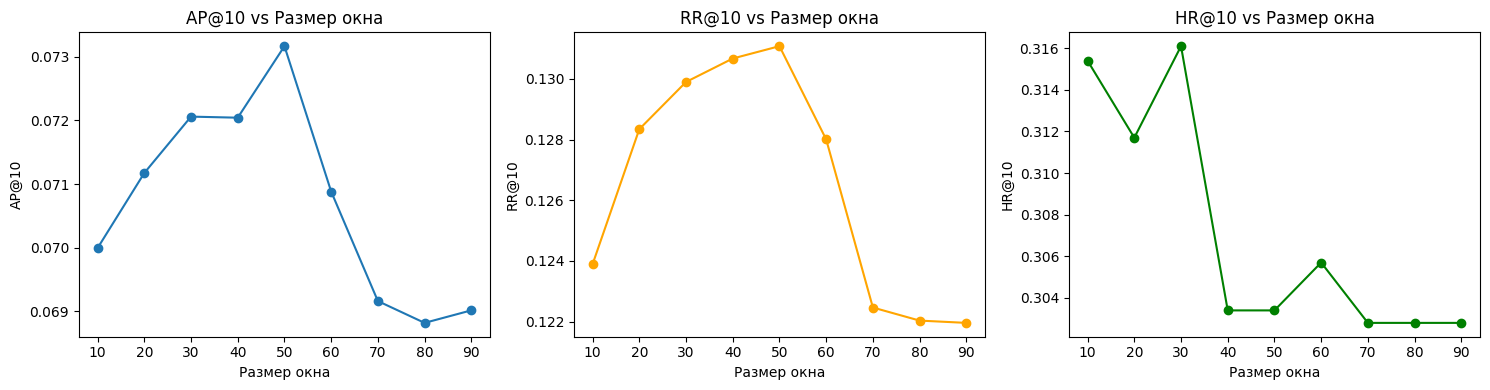

In [ ]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.plot(window_sizes, ap_scores, marker='o')
plt.title(f'AP@{topn} vs Размер окна')
plt.xlabel('Размер окна')
plt.ylabel(f'AP@{topn}')

plt.subplot(1, 3, 2)
plt.plot(window_sizes, rr_scores, marker='o', color='orange')
plt.title(f'RR@{topn} vs Размер окна')
plt.xlabel('Размер окна')
plt.ylabel(f'RR@{topn}')

plt.subplot(1, 3, 3)
plt.plot(window_sizes, hr_scores, marker='o', color='green')
plt.title(f'HR@{topn} vs Размер окна')
plt.xlabel('Размер окна')
plt.ylabel(f'HR@{topn}')

plt.tight_layout()
plt.show()

Подумайте и ответьте, как размер окна влияет на качество рекомендаций. Какое значение наилучшее, есть ли у этого разумное объяснение?

**Ответ:**  
	1.	AP@10: Растёт до окна 50 дней, затем падает. Недавние и среднесрочные данные полезнее для точности.  
	2.	RR@10: Максимум на 40-50 днях, затем снижение. Свежие тренды важны, но слишком старые данные ухудшают ранжирование.  
	3.	HR@10: Резкий спад после 30 дней, небольшое восстановление на 60, но в целом ниже.  

Оптимальный размер окна - это 30-50 дней: баланс между актуальностью и стабильностью рекомендаций.

**Задание №3. Метрики и k.**

Постройте зависимость значений MAP@K, MRR@K, HR@K для метода рекомендации по популярности. Возьмите какие-нибудь k, например, от 1 до 100, переберите значения и покажите на линейном графике.

In [ ]:
joined['toppopular_recs'] = toppop.predict(joined, topn=100)

In [ ]:
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs
0,96,"[(15297, 148)]","[(12360, 158)]","[42, 11857, 7102]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
1,373,"[(2154, 120)]","[(3734, 157)]","[42, 11857, 7102]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
2,414,"[(10440, 152), (2940, 152)]","[(10100, 153), (4143, 153), (9873, 153), (142,...","[42, 11857, 7102]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
3,515,"[(3734, 114), (9728, 114), (4457, 115), (13865...","[(512, 158), (6330, 158), (9811, 159), (14488,...","[42, 11857, 7102]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
4,565,"[(3734, 114), (15297, 114), (4151, 146)]","[(4260, 160)]","[42, 11857, 7102]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."


До 100 считает ооочень долго, падает несколько раз Runtime в google colab, поэтому возьмем k от 1 до 29.

In [ ]:
k_values = range(1, 30)
map_scores = []
mrr_scores = []
hr_scores = []

for k in k_values:
    map_list = []
    mrr_list = []
    hr_list = []
    for idx, row in joined.iterrows():
        gt_items = [item for item, _ in row['test_interactions']]
        predictions = row['toppopular_recs']
        map_list.append(ap_metric(gt_items, predictions, topn=k))
        mrr_list.append(rr_metric(gt_items, predictions, topn=k))
        hr_list.append(hr_metric(gt_items, predictions, topn=k))
    map_scores.append(np.mean(map_list))
    mrr_scores.append(np.mean(mrr_list))
    hr_scores.append(np.mean(hr_list))

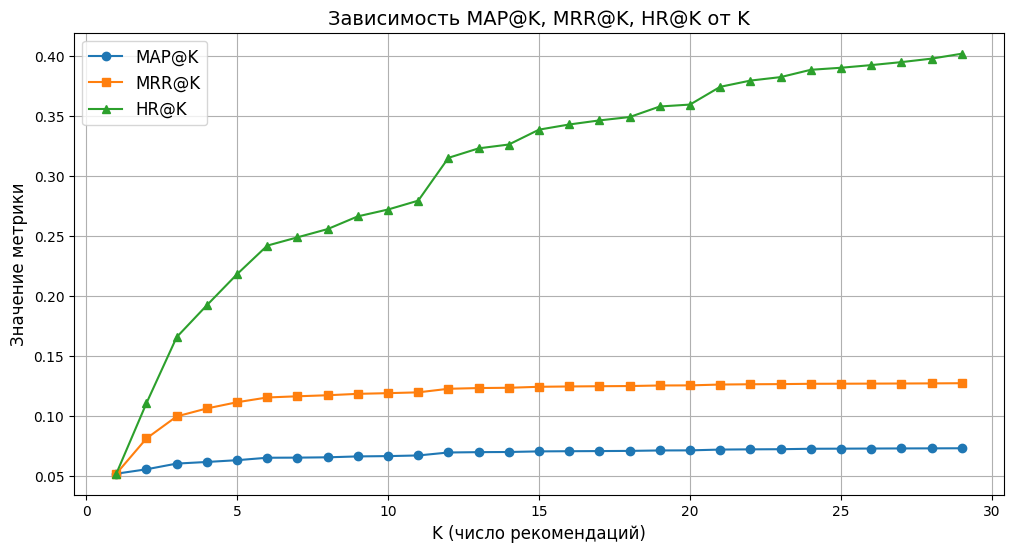

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(k_values, map_scores, label=f"MAP@K", marker='o')
plt.plot(k_values, mrr_scores, label=f"MRR@K", marker='s')
plt.plot(k_values, hr_scores, label=f"HR@K", marker='^')

plt.xlabel("K (число рекомендаций)", fontsize=12)
plt.ylabel("Значение метрики", fontsize=12)
plt.title(f"Зависимость MAP@K, MRR@K, HR@K от K", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

Хорошенько подумайте и ответьте на вопросы ниже.

3.1 Какие из метрик являются монотонными функциями по top-K? Объясните, почему они являются монотонными? \
**Ответ:**  
* HR@K – монотонно возрастает. Чем больше K, тем выше вероятность, что хотя бы один из релевантных объектов попадёт в рекомендации.  
* MAP@K и MRR@K не являются строго монотонными, так как они учитывают порядок и качество ранжирования рекомендаций, но в целом MAP@K остаётся относительно стабильным, а MRR@K немного растёт и затем выходит на плато.


3.2 Объясните по каждой метрике, как можно интерпретировать ее график? То есть, что можно сказать про связь изменения метрики c возможными пользовательскими сценариями, например,скроллингом ленты новостей. \
**Ответ:**  
* HR@K: Чем больше рекомендаций, тем выше вероятность, что пользователь найдёт что-то полезное. Это похоже на бесконечную ленту новостей – чем больше скроллим, тем больше шанс наткнуться на интересный контент.
* MRR@K: Растёт медленно и выходит на плато. Это показывает, что наибольшая ценность рекомендаций – в первых нескольких позициях. Например, в поисковой системе важны первые результаты, а дальше пользователь редко смотрит.
* MAP@K: Практически не изменяется – это значит, что добавление рекомендаций мало влияет на среднюю точность. В реальной жизни это можно сравнить с тем, что пользователь чаще находит полезное в первых 5-10 рекомендациях, а дальше точность не увеличивается.

3.3 Как вы думаете, почему графики выглядят именно так? Должны ли они возрастать/убывать, от чего это может зависеть? (Тут вам может помочь дополнительный анализ данных)\
**Ответ:**  
* HR@K закономерно растёт, потому что чем больше рекомендаций, тем выше шанс найти релевантный объект.
* MRR@K стабилизируется, так как учитывает ранжирование – добавление рекомендаций не сильно меняет первый релевантный элемент.
* MAP@K остаётся почти неизменным, потому что на больших K новые рекомендации часто нерелевантны.

Такое поведение ожидаемо для рекомендаций по популярности: важны первые позиции, а увеличение K в основном улучшает HR, но не точность и ранжирование.

**Задание №4. Интерпретация рейтингов**

Возьмите названия фильмов/сериалов из `items.csv`, выделите 5 различных сценариев изменения популярности у фильмов, аргументируйте (например, графиком или статистикой) и проинтерпретируейте их (почему популярность для этого фильма меняется так). Обратите внимание, что надо найти именно разные паттерны изменения вероятностей.

In [ ]:
items = pd.read_csv('/content/drive/My Drive/datasets/recsys_course/items.csv')[['item_id','title']].copy()
items.head()

,item_id,title
0,10711,Поговори с ней
1,2508,Голые перцы
2,10716,Тактическая сила
3,7868,45 лет
4,16268,Все решает мгновение


Пример:

In [ ]:
df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,59,4250,72.0
1,699317,1659,77,8317,100.0
2,656683,7107,57,10,0.0
3,864613,7638,114,14483,100.0
4,964868,9506,48,6725,100.0


1917


<Axes: >

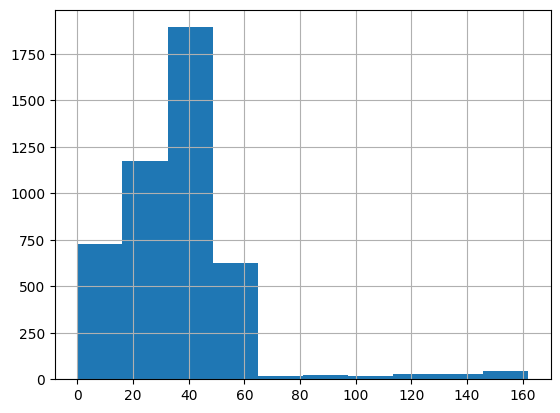

In [ ]:
popular_items = df.item_id.value_counts()[:300].index.tolist()
sampled_id = np.random.choice(popular_items)

# это для примера, хотя выцеплять случаи по одному может быть не лучшей идеей
sampled_id = 3402

interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist()

Фильм 1917 какое-то время набирал популярность, потом видим резкое падение (кстати, с какой даты?). Возможно, это связано с ограничением доступности этого фильма для части пользователей, периодом проката фильма / рекламной кампании или другой причиной.

Добавьте 5 своих примеров ниже. Опишите, как вы их искали.

Ох. Непростое и творческое задание. Ну да ладно.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

1. Определяем диапазон времени (last_watch_dt) и создаём бины.

In [ ]:
min_time = df['last_watch_dt'].min()
max_time = df['last_watch_dt'].max()
num_bins = 10
bins = np.linspace(min_time, max_time, num_bins + 1)

2. Для каждого фильма (item_id) строим гистограмму (вектор длины num_bins). Возьмем первые 5000 из 15000 фильмов, чтобы побыстрее.

In [ ]:
item_ids = df['item_id'].unique()[:5000]
hist_list = []
for item in item_ids:
    times = df.loc[df['item_id'] == item, 'last_watch_dt']
    hist, _ = np.histogram(times, bins=bins)
    hist_list.append(hist)

hist_data = np.array(hist_list)

3. Нормализуем каждую гистограмму так, чтобы сумма по бин-колонкам была равна 1, далее масштабируем и кластеризуем наши данные.

In [ ]:
hist_normalized = hist_data / (hist_data.sum(axis=1, keepdims=True) + 1e-8)
scaler = StandardScaler()
X = scaler.fit_transform(hist_normalized)

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X)
cluster_df = pd.DataFrame({'item_id': item_ids, 'cluster': clusters})

In [ ]:
cluster_df.cluster.value_counts()

,count
cluster,
0,2871
2,658
3,655
1,604
4,212


6. Для каждого кластера выбираем представителя. Как вариант - выбираем фильм с наибольшим числом событий из исходных данных.

In [ ]:
representatives = {}
for cluster in range(n_clusters):
    cluster_items = cluster_df.loc[cluster_df['cluster'] == cluster, 'item_id']
    best_item = None
    best_count = -1
    for item in cluster_items:
        count = df.loc[df['item_id'] == item].shape[0]
        if count > best_count:
            best_count = count
            best_item = item
    representatives[cluster] = best_item

print("Представители кластеров (item_id):", representatives)

Представители кластеров (item_id): {0: 10440, 1: 11237, 2: 3734, 3: 6809, 4: 7793}


7. Визуализируем гистограммы (распределение просмотров по времени) для каждого представителя.

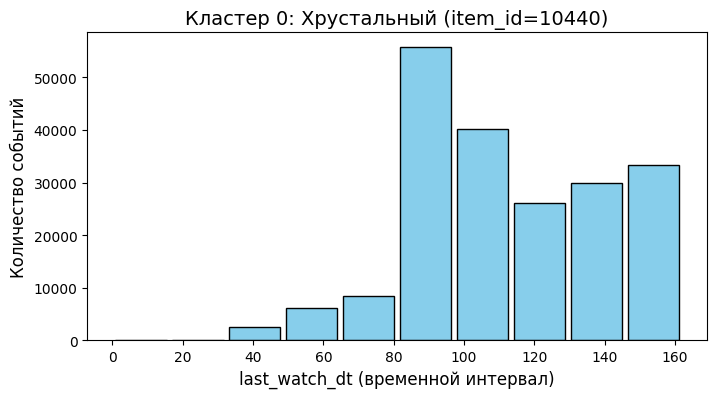

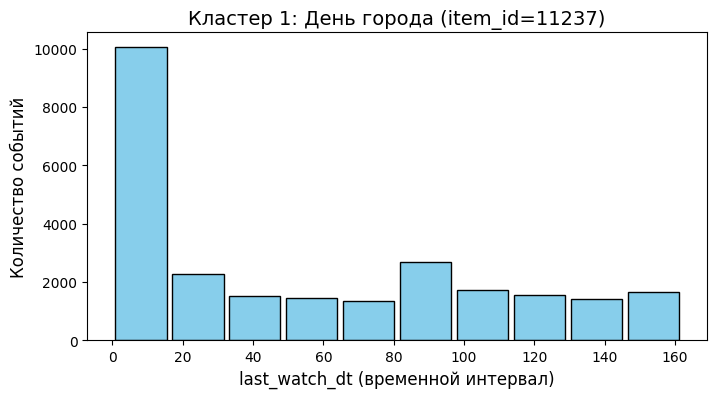

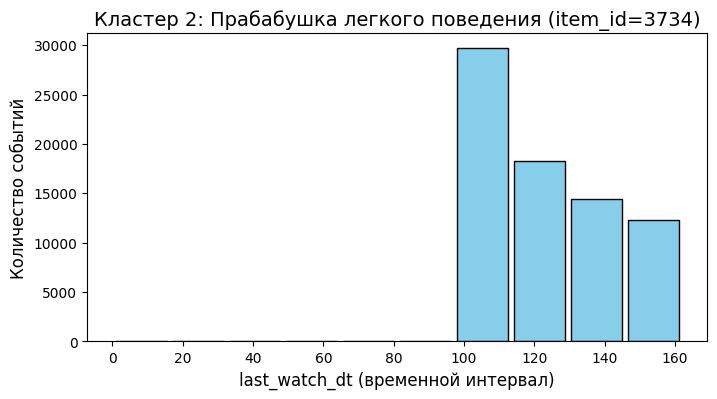

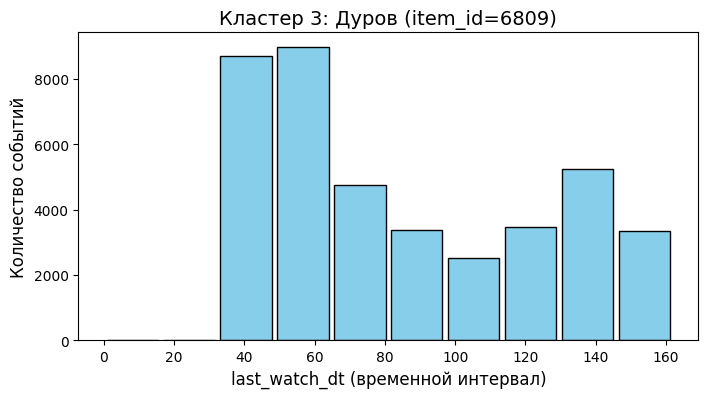

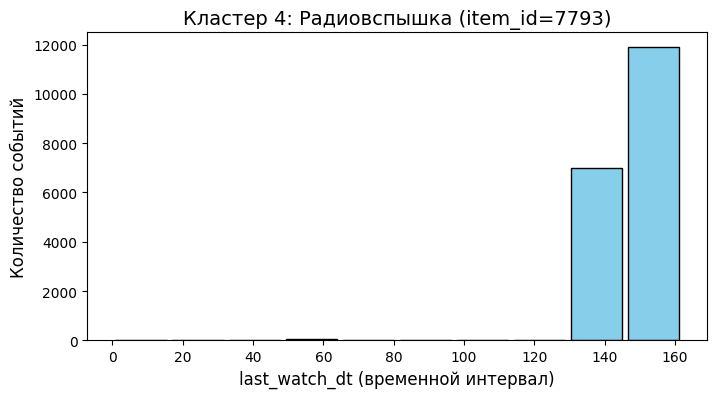

In [ ]:
for cluster, rep_item in representatives.items():
    rep_times = df.loc[df['item_id'] == rep_item, 'last_watch_dt']
    rep_hist, _ = np.histogram(rep_times, bins=bins)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    if rep_item in items.item_id.values:
        title = items.loc[items.item_id == rep_item, 'title'].values[0]
    else:
        title = f"Item {rep_item}"

    plt.figure(figsize=(8, 4))
    plt.bar(bin_centers, rep_hist, width=(bins[1] - bins[0]) * 0.9, color='skyblue', edgecolor='black')
    plt.title(f"Кластер {cluster}: {title} (item_id={rep_item})", fontsize=14)
    plt.xlabel("last_watch_dt (временной интервал)", fontsize=12)
    plt.ylabel("Количество событий", fontsize=12)
    plt.show()

* Фильм Хрустальный. Странный фильм. В самом начале его почти никто не смотрел, а только спустя месяц просмотры росли и на третий месяц достигли максимума. Далее болтались чуть ниже максимума.
* Фильм День города. Взрывной рост просмотров в первые 20 дней. Далее просмотров в 5 раз меньше, но зато стабильно.
* Прабабушка легкого поведения. Типичная комедия, которую никто не смотрел, потом на 3 месяц кто-то сделал мемчик, и фильм порвал все онлайн-кинотеатры со смеху.
* Дуров. Интересный выбор. Видимо, месяц публика изучала, о ком же этот фильм, а как поняли, что про создателя телеграмм - побежали смотреть.  
* Радиовспышка. Интересно. 4 месяца фильм был никому не нужен. Далее месяц больших просмотров.

**Задание №5. User-item encoding**

Теперь, создайте матрицу интеракций user-item по примеру из семинара. Вам нужно в итоге получить разреженную матрицу (sparse matrix), в которой в качестве строк будут пользователи, в качестве колонок - айтемы. Не забудьте перекодировать пользователей и айтемы через энкодер. В отличие от семинара, оставьте в матрице только юзеров и айтемы, которые встречались в матрице > 4 раз.

Важно: когда вы отфильтруете юзеров на встречаемость > 4 раз, вы удалите какие-то айтемы, которые теперь станут встречаться меньше 5 раз. Поэтому у вас перестанет выполняться второе условие на минимальное число интеракций с айтемом. Тогда вам надо опять отфильтровать айтемы на встречаемость, но это снова может нарушить условие для юзеров. В таком случае, вам надо написать итеративный алгоритм до сходимости, пока требования не будут выполняться в обеих колонках.

In [ ]:
train_df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
55,897955,13933,88,6394,97.0
73,820464,3071,35,4708,80.0
145,141072,7308,119,8657,100.0
204,413440,7310,132,1,0.0
219,217512,10942,145,3984,48.0


In [ ]:
df.shape, train_df.shape

((5476250, 5), (124324, 5))

In [ ]:
def filter_column(df, min_freq):
    """
    Filter dataframe, excluding least active users and least popular items.
    Return a copy of the dataframe with at least min_freq entries
    in both users and items
    """
    user_counts = df['user_id'].value_counts()
    valid_users = user_counts[user_counts >= min_freq].index
    df_filtered = df[df['user_id'].isin(valid_users)]

    item_counts = df_filtered['item_id'].value_counts()
    valid_items = item_counts[item_counts >= min_freq].index
    df_filtered = df_filtered[df_filtered['item_id'].isin(valid_items)]
    return df_filtered.copy()

def filter_dataframe(df, cols, min_freq=5):
    """
    Filter dataframe by given columns until each of them satisfies
    min_freq condition, guaranteed by filter_columns. Return a copy
    of the dataframe
    """
    df_filtered = df.copy()
    while True:
        prev_rows = df_filtered.shape[0]
        df_filtered = filter_column(df_filtered, min_freq)
        valid = True
        for col in cols:
            counts = df_filtered[col].value_counts()
            if (counts < min_freq).any():
                valid = False
                break
        if valid or df_filtered.shape[0] == prev_rows:
            break
    return df_filtered.copy()

In [ ]:
filtered_train = filter_dataframe(train_df, ['user_id', 'item_id'], min_freq=5)
filtered_train.shape

(108603, 5)

In [ ]:
item2id = {k: v for v, k in enumerate(filtered_train.item_id.unique())}
user2id = {k: v for v, k in enumerate(filtered_train.user_id.unique())}
id2item = {v: k for k, v in item2id.items()}
id2user = {v: k for k, v in user2id.items()}

In [ ]:
def df_encode(df):
    item2id = {k:v for v, k in enumerate(df.item_id.unique())}
    user2id = {k:v for v, k in enumerate(df.user_id.unique())}

    id2item = {k:v for v, k in item2id.items()}
    id2user = {k:v for v, k in user2id.items()}

    df['user_id'] = df.user_id.apply(lambda x: user2id[x])
    df['item_id'] = df.item_id.apply(lambda x: item2id[x])
    return df

filtered_train = df_encode(filtered_train)
filtered_train.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
4264833,591,198,63,71,74.0
694629,151,1365,79,2372,100.0
2328187,5857,201,66,5,0.0
4663577,4107,549,137,5318,82.0
568312,2380,1777,17,6219,100.0


In [ ]:
from scipy import sparse as sps

matrix = sps.coo_matrix(
    (np.ones(filtered_train.shape[0]), (filtered_train['user_id'], filtered_train['item_id'])),
    shape=(len(user2id), len(item2id)),
)
matrix

<5938x3099 sparse matrix of type '<class 'numpy.float64'>'
	with 108603 stored elements in COOrdinate format>

**Задание №6. Интеракции и частота**

Постройте график зависимости количества айтемов и юзеров от значений (порогов) фильтров на встречаемость в матрице интеракций. То есть, нужно выполнить задание №5 для нескольких значений `min_freq` и построить график зависимости числа оставшихся айтемов и юзеров от этого параметра.

Переберем значения порога от 1 до 15, например.

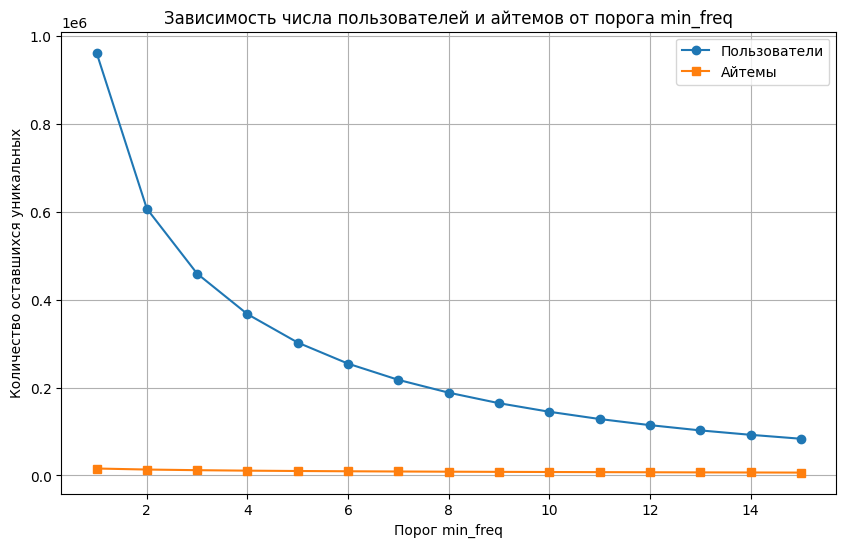

In [ ]:
min_freq_values = range(1, 16)
users_counts = []
items_counts = []

for m in min_freq_values:
    filtered = filter_dataframe(df, ['user_id', 'item_id'], min_freq=m)
    users_counts.append(len(filtered['user_id'].unique()))
    items_counts.append(len(filtered['item_id'].unique()))

plt.figure(figsize=(10,6))
plt.plot(min_freq_values, users_counts, marker='o', label='Пользователи')
plt.plot(min_freq_values, items_counts, marker='s', label='Айтемы')
plt.xlabel('Порог min_freq')
plt.ylabel('Количество оставшихся уникальных')
plt.title('Зависимость числа пользователей и айтемов от порога min_freq')
plt.legend()
plt.grid(True)
plt.show()

**Задание №7. EASE**

Реализуйте EASE, постройте рекомендации для юзеров. Сравните все имплементированные ранее метрики качества с `TopPopular` для некоторого набора k.

Реализацию можно взять из семинара. Можно реализовать по статье https://arxiv.org/pdf/1905.03375.pdf. Можно взять и адаптировать из RecBole https://github.com/RUCAIBox/RecBole.

In [ ]:
%%time

# Обучаем конечную модель
# Мы взяли реализацию из RecBole
#
def fit_ease(X, reg_weight=1000):

    G = X.T @ X
    G += reg_weight * sps.identity(G.shape[0])
    G = G.todense()
    P = np.linalg.inv(G)
    B = P / (-np.diag(P))
    np.fill_diagonal(B, 0.)

    return B

w = fit_ease(matrix)

CPU times: user 4.88 s, sys: 395 ms, total: 5.28 s
Wall time: 3.3 s


In [ ]:
w.shape

(3099, 3099)

Далее, вам надо реализовать функцию получения предсказаний. У вас есть обученная матрица весов, которую можно использовать для получения предсказаний. Для этого нужно построить вектор интеракций пользователя и умножить его на матрицу весов.

In [ ]:
filtered_train.shape

(108603, 5)

In [ ]:
def get_preds(x, item2id, id2item):

    user_items = [t[0] for t in x]
    encoded = [item2id[t] for t in user_items if t in item2id]
    vector = np.zeros(len(item2id))
    vector[encoded] = 1
    vector = sps.csr_matrix(vector)

    preds = np.array(vector.dot(w))[0]
    preds[encoded] = -np.inf
    ranks = np.argsort(-preds)
    decoded = [id2item[t] for t in ranks][:100]

    return decoded


joined['ease_preds'] = joined.train_interactions.apply(lambda x: get_preds(x, item2id, id2item))
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs,ease_preds
0,96,"[(15297, 148)]","[(12360, 158)]","[42, 11857, 7102]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[10440, 4151, 9728, 3734, 13865, 16228, 12192,..."
1,373,"[(2154, 120)]","[(3734, 157)]","[42, 11857, 7102]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[4151, 13865, 8636, 7971, 7946, 4976, 13018, 1..."
2,414,"[(10440, 152), (2940, 152)]","[(10100, 153), (4143, 153), (9873, 153), (142,...","[42, 11857, 7102]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[15297, 13865, 9728, 2657, 9996, 3734, 142, 41..."
3,515,"[(3734, 114), (9728, 114), (4457, 115), (13865...","[(512, 158), (6330, 158), (9811, 159), (14488,...","[42, 11857, 7102]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[10440, 4151, 4880, 2657, 142, 12192, 8636, 78..."
4,565,"[(3734, 114), (15297, 114), (4151, 146)]","[(4260, 160)]","[42, 11857, 7102]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[10440, 13865, 4880, 9728, 142, 2657, 12192, 1..."


Вспомним все метрики и заново их тут выведем:

In [ ]:
evaluate_recommender(joined, model_preds='random_recs')

{'map': 0.0025388888888888887, 'mrr': 0.0054666666666666665, 'hr': 0.0164}

In [ ]:
evaluate_recommender(joined, model_preds='toppopular_recs')

{'map': 0.07605959737638346, 'mrr': 0.13022644323001428, 'hr': 0.5597}

In [ ]:
evaluate_recommender(joined, model_preds='ease_preds')

{'map': 0.09538685579142327, 'mrr': 0.167452976757537, 'hr': 0.6165}

Сделайте выводы — какой алгоритм работает лучше?

**Ответ:**  
Ух ты! Лучше по всем метрикам работает алгоритм EASE.

**Задание №8. Тюнинг**

Переберите различные значения гиперпараметра коэффициента регуляризации у EASE и постройте графики, как в задании №6. Постарайтесь "затюнить" EASE как можно лучше. Возьмите разумное число гиперпараметров - хотя бы штук 20 по логарифмической сетке, либо используйте более хитрые алгоритмы оптимизации.

Я брал reg_weight от 1 до 1000, на графиках все росло и росло, так что любопытно, что будет от 1 до 10000. Проверим.

In [ ]:
reg_weights = np.logspace(np.log10(10), np.log10(10000), num=20)
reg_weights

array([   10.        ,    14.38449888,    20.69138081,    29.76351442,
          42.81332399,    61.58482111,    88.58667904,   127.42749857,
         183.29807108,   263.66508987,   379.26901907,   545.55947812,
         784.75997035,  1128.83789168,  1623.77673919,  2335.72146909,
        3359.81828628,  4832.93023857,  6951.92796178, 10000.        ])

In [ ]:
%%time
map_scores = []
mrr_scores = []
hr_scores = []

for reg in reg_weights:
    w = fit_ease(matrix, reg_weight=reg)
    joined['ease_preds'] = joined.train_interactions.apply(lambda x: get_preds(x, item2id, id2item))
    metrics = evaluate_recommender(joined, model_preds='ease_preds')
    map_scores.append(metrics['map'])
    mrr_scores.append(metrics['mrr'])
    hr_scores.append(metrics['hr'])

CPU times: user 6min 57s, sys: 10.1 s, total: 7min 7s
Wall time: 6min 32s


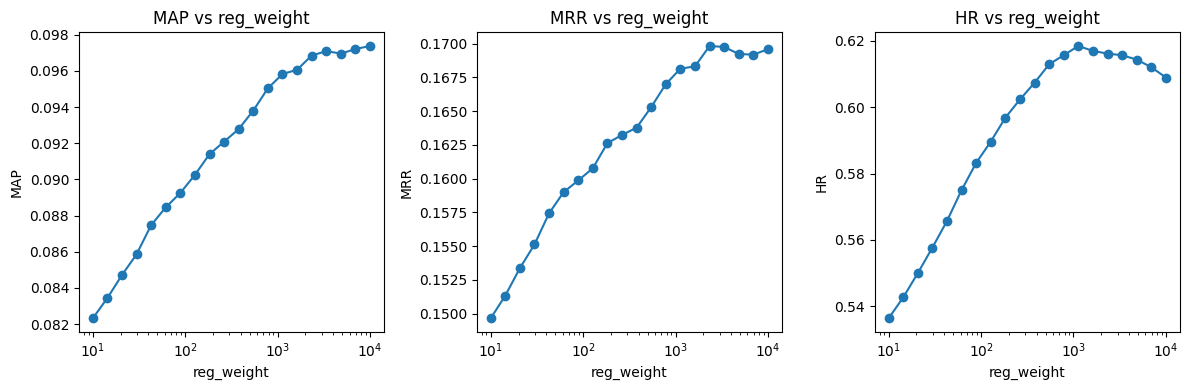

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.semilogx(reg_weights, map_scores, marker='o', linestyle='-')
plt.xlabel('reg_weight')
plt.ylabel('MAP')
plt.title('MAP vs reg_weight')

plt.subplot(1,3,2)
plt.semilogx(reg_weights, mrr_scores, marker='o', linestyle='-')
plt.xlabel('reg_weight')
plt.ylabel('MRR')
plt.title('MRR vs reg_weight')

plt.subplot(1,3,3)
plt.semilogx(reg_weights, hr_scores, marker='o', linestyle='-')
plt.xlabel('reg_weight')
plt.ylabel('HR')
plt.title('HR vs reg_weight')

plt.tight_layout()
plt.show()

Ответьте на следующие вопросы:

8.1 Какое значение гиперпараметра является наилучшим?


**Ответ:**  
Лучший reg_weight находится в диапазоне 3000-5000, так как обеспечивает баланс между MAP, MRR и HR.

8.2 Что еще интересного вы можете сказать по графикам? Может быть, что-то свзяанное с распределением параметров, влиянием на отдельные метрики, скоростью тюнинга?

**Ответ:**  
* MAP и MRR растут с увеличением reg_weight, но HR сначала растет, затем падает после 5000.
* Слишком высокая регуляризация снижает разнообразие предсказаний и ухудшает HR.
* Оптимальный баланс достигается в среднем диапазоне reg_weight (1000-5000).
* Тюнинг занял 6 минут, можно ускорить с помощью hyperopt или optuna.

**Задание №9. EASE и topk**

В лекции №2 говорилось, что качество у EASE растет с ослаблением фильтра на число айтемов. В этом задании постройте кривые метрик качества MAP/MRR/HR в зависимости от topk (например, от 1 до 100 с некоторым шагом), где кривая параметризована минимальным требуемым значением встречаемости user/item (из задания №6). Опишите свои выводы.

Важно: в этом задании линии могут быть мало различимыми, поэтому ваша задача для каждой метрики найти нужный масштаб на каких-то конкретных topk, чтобы линии стали визуально отличимы.

topk от 1 до 100 очень долго считаются. Возьмем от 1 до 41.

In [ ]:
list(range(1, 42, 10))

[1, 11, 21, 31, 41]

In [ ]:
min_freq_values = [1, 7, 13]
topk_values = list(range(1, 42, 10))

results_map = {m: [] for m in min_freq_values}
results_mrr = {m: [] for m in min_freq_values}
results_hr  = {m: [] for m in min_freq_values}

In [ ]:
%%time
for m in min_freq_values:
    print(f"\nОбработка min_freq = {m}")
    filtered_train_raw = filter_dataframe(df, ['user_id', 'item_id'], min_freq=m)
    print(f"  Размер после фильтрации: {filtered_train_raw.shape}")

    item2id = {k: v for v, k in enumerate(filtered_train_raw.item_id.unique())}
    id2item = {v: k for k, v in item2id.items()}
    user2id = {k: v for v, k in enumerate(filtered_train_raw.user_id.unique())}
    id2user = {v: k for k, v in user2id.items()}
    filtered_train = df_encode(filtered_train_raw)
    num_users = filtered_train['user_id'].max() + 1
    num_items = filtered_train['item_id'].max() + 1
    matrix = sps.coo_matrix(
        (np.ones(filtered_train.shape[0]), (filtered_train['user_id'], filtered_train['item_id'])),
        shape=(num_users, num_items)
    )
    print(f"  Разреженная матрица: {matrix.shape}")

    w = fit_ease(matrix, reg_weight=100)

    for k in topk_values:
        joined['ease_preds'] = joined.train_interactions.apply(lambda x: get_preds(x, item2id, id2item)[:k])

        metrics = evaluate_recommender(joined, model_preds='ease_preds')
        results_map[m].append(metrics['map'])
        results_mrr[m].append(metrics['mrr'])
        results_hr[m].append(metrics['hr'])

        print(f"  min_freq {m}, topk {k}: MAP={metrics['map']:.4f}, MRR={metrics['mrr']:.4f}, HR={metrics['hr']:.4f}")


Обработка min_freq = 1
  Размер после фильтрации: (5476250, 5)
  Разреженная матрица: (962179, 15706)
  min_freq 1, topk 1: MAP=0.1034, MRR=0.1034, HR=0.1034
  min_freq 1, topk 11: MAP=0.0970, MRR=0.1761, HR=0.3815
  min_freq 1, topk 21: MAP=0.1027, MRR=0.1823, HR=0.4790
  min_freq 1, topk 31: MAP=0.1060, MRR=0.1848, HR=0.5438
  min_freq 1, topk 41: MAP=0.1081, MRR=0.1862, HR=0.5919

Обработка min_freq = 7
  Размер после фильтрации: (3811578, 5)
  Разреженная матрица: (217378, 8919)
  min_freq 7, topk 1: MAP=0.0996, MRR=0.0996, HR=0.0996
  min_freq 7, topk 11: MAP=0.0938, MRR=0.1720, HR=0.3761
  min_freq 7, topk 21: MAP=0.0994, MRR=0.1783, HR=0.4753
  min_freq 7, topk 31: MAP=0.1024, MRR=0.1806, HR=0.5358
  min_freq 7, topk 41: MAP=0.1044, MRR=0.1819, HR=0.5811

Обработка min_freq = 13
  Размер после фильтрации: (2760597, 5)
  Разреженная матрица: (102405, 6890)
  min_freq 13, topk 1: MAP=0.0965, MRR=0.0965, HR=0.0965
  min_freq 13, topk 11: MAP=0.0905, MRR=0.1681, HR=0.3725
  min_fre

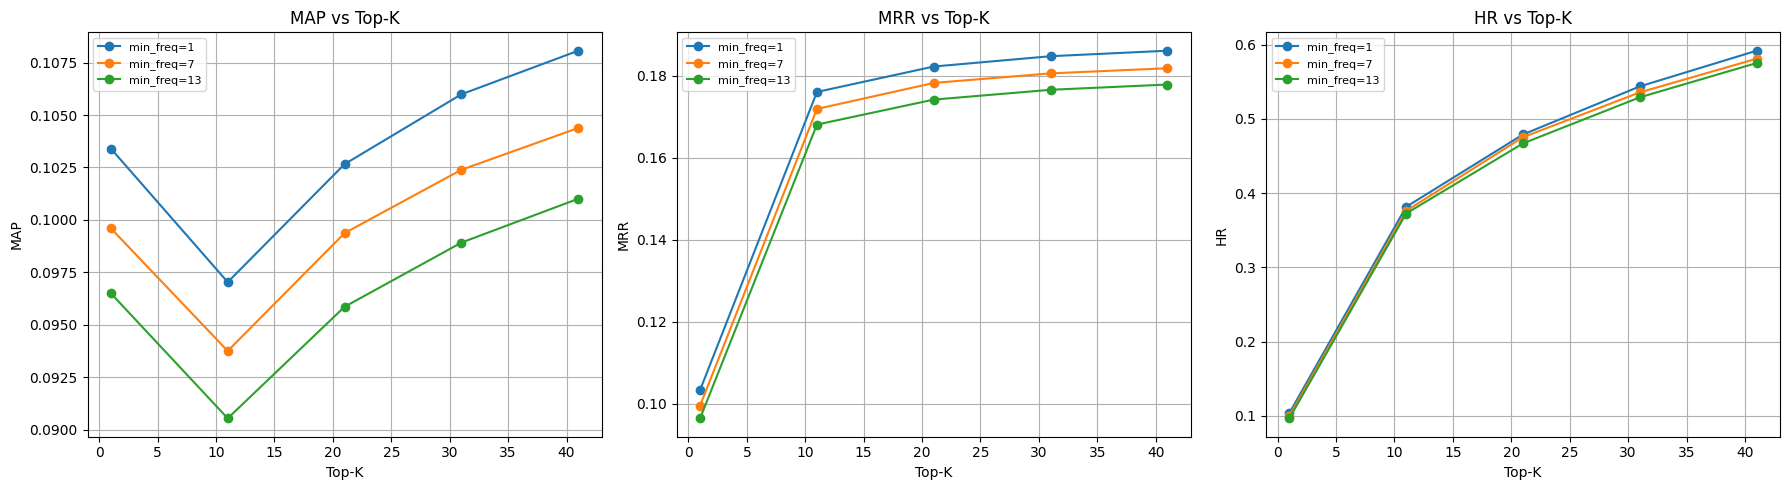

In [ ]:
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
for m in min_freq_values:
    plt.plot(topk_values, results_map[m], marker='o', label=f"min_freq={m}")
plt.xlabel("Top-K")
plt.ylabel("MAP")
plt.title("MAP vs Top-K")
plt.legend(fontsize=8)
plt.grid(True)

plt.subplot(1,3,2)
for m in min_freq_values:
    plt.plot(topk_values, results_mrr[m], marker='o', label=f"min_freq={m}")
plt.xlabel("Top-K")
plt.ylabel("MRR")
plt.title("MRR vs Top-K")
plt.legend(fontsize=8)
plt.grid(True)

plt.subplot(1,3,3)
for m in min_freq_values:
    plt.plot(topk_values, results_hr[m], marker='o', label=f"min_freq={m}")
plt.xlabel("Top-K")
plt.ylabel("HR")
plt.title("HR vs Top-K")
plt.legend(fontsize=8)
plt.grid(True)

plt.tight_layout()
plt.show()

Что вы можете сказать на основе полученных графиков? Соответствуют ли они вашим ожиданиям?

**Ответ:**  
* С увеличением top‑K: HR растёт, а MRR быстро достигает плато (примерно при top‑K от 30 до 50).
* При более мягком фильтре (min_freq=1): метрики (MAP, MRR, HR) немного выше, чем при более строгих порогах (min_freq=7 или 13).
* Вывод - ослабление фильтра (то есть меньшее отсечение) даёт чуть лучшие рекомендации, что соответствует сказанному на лекции. При этом разница невелика, что говорит о стабильности сигнала даже при более жесткой фильтрации.

**Задание №10. Интерпретируемые рекомендации**

Используйте выученную матрицу весов для item2item рекомендаций. Приведите 10 примеров топ-5 рекомендаций от EASE к сэмплируемым айтемам. Используйте названия фильмов вместо id при выводе рекомендаций.

In [ ]:
w

matrix([[ 0.00000000e+00,  9.80993602e-03, -5.40367737e-04, ...,
          6.79787142e-04,  3.66196335e-04,  4.56516698e-04],
        [ 3.14460398e-02,  0.00000000e+00, -1.07741602e-03, ...,
          1.04577430e-04, -5.08322291e-04,  7.39850727e-04],
        [-2.55518452e-03, -1.58933886e-03,  0.00000000e+00, ...,
          1.16294922e-04, -8.53602205e-05,  7.22474452e-07],
        ...,
        [ 1.13477565e-02,  5.44596999e-04,  4.10548963e-04, ...,
          0.00000000e+00, -6.34740185e-07, -4.54866626e-04],
        [ 6.24105645e-03, -2.70261067e-03, -3.07656991e-04, ...,
         -6.48041840e-07,  0.00000000e+00, -1.13560822e-04],
        [ 7.79826059e-03,  3.94262432e-03,  2.60994114e-06, ...,
         -4.65466131e-04, -1.13821810e-04,  0.00000000e+00]])

In [ ]:
w.shape

(6890, 6890)

In [ ]:
item_titles = dict(zip(items.item_id, items.title))
num_items = w.shape[0]
sampled_indices = np.random.choice(num_items, 10, replace=False)

In [ ]:
for idx in sampled_indices:
    row = np.array(w[idx, :]).flatten()
    row[idx] = -np.inf
    top5_indices = np.argsort(-row)[:5]
    rec_item_ids = [id2item[i] for i in top5_indices]
    rec_titles = [item_titles.get(item_id, str(item_id)) for item_id in rec_item_ids]
    orig_item_id = id2item[idx]
    orig_title = item_titles.get(orig_item_id, str(orig_item_id))
    print(f"Рекомендации для фильма '{orig_title}' (id={orig_item_id}):")
    for rank, title in enumerate(rec_titles, 1):
        print(f"  {rank}. {title}")
    print()

Рекомендации для фильма 'Девочка' (id=10780):
  1. Студентка по вызову
  2. Анатомия измены
  3. Белый снег
  4. Дочь волка
  5. Нимфоманка. Фильм второй

Рекомендации для фильма 'Сердце моё' (id=2676):
  1. Любовь между строк
  2. Глубокое синее море
  3. Леди Макбет
  4. Смертельный номер
  5. Волшебная флейта

Рекомендации для фильма 'Шакал' (id=8489):
  1. Морской бой
  2. Трудная мишень
  3. [4К] Гнев человеческий
  4. Doom: Аннигиляция
  5. Водный мир

Рекомендации для фильма 'Путешествие времени' (id=1324):
  1. 2067: Петля времени
  2. Явление
  3. Цвет из иных миров
  4. Во власти стихии
  5. Разлом

Рекомендации для фильма 'Гномы в доме' (id=11494):
  1. Мы – монстры
  2. Рок Дог
  3. Большой собачий побег
  4. Головоломка
  5. Гномео и Джульетта

Рекомендации для фильма 'Открытое море' (id=2540):
  1. В пасти океана
  2. Синяя бездна
  3. Хрустальный
  4. Послезавтра
  5. Чкалов

Рекомендации для фильма 'Шрек Третий' (id=2836):
  1. Шрек навсегда
  2. Шрек 2
  3. Гринч
  4. 

Хорошие ли получились рекомендации? Почему? Есть ли хорошие примеры? Есть ли плохие? Почему бывают плохие примеры?

**Ответ:**  
Не смотрел фильм Девочка, но рекомендации к ней весьма странные... И смешно и больно.
Но в целом, примеры с франшизами (как Шрек или Последний богатырь) выглядят хорошими и интерпретируемыми, так как они отражают явное item-to-item сходство на основе совместных просмотров. С другой стороны, для некоторых фильмов (например, Девочка или Шакал) рекомендации кажутся менее осмысленными, что может быть следствием шума в данных или недостатка дополнительной информации о фильмах. Это подчёркивает ограниченность подхода EASE, который полагается только на статистику интеракций, и указывает на потенциал для улучшения за счёт включения контекстной или контентной информации.

Уух. Кажется, все. Спасибо за домашнее задание. Было интересно и трудно!